### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [ ]:
# !wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip

In [1]:
import numpy as np
import cv2

IMG_HEIGHT = 600
#SIGN_SIZE = (224, 224)
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('../FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('../FullIJCNN2013', range(600,900), range(852,1213))

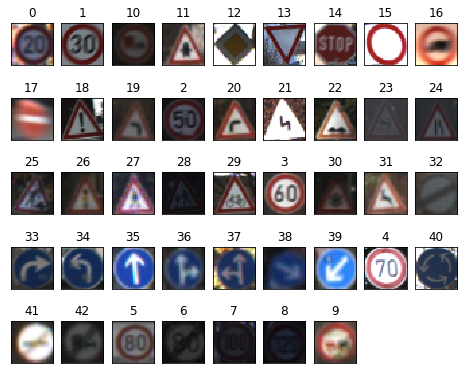

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

cnn = Sequential()
## If You preprocessed with gray scaling and local histogram equivalization then input_shape = (32,32,1) else (32,32,3)
cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
#cnn.add(Flatten())
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.7))
cnn.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxP

In [9]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto')

data = cnn.fit(tr_signs, tr_labels, batch_size=128, epochs=1000, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard, early_stopping])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/1000
 - 0s - loss: 0.0688 - acc: 0.9883 - val_loss: 0.1814 - val_acc: 0.9603
Epoch 2/1000
 - 0s - loss: 0.0574 - acc: 0.9867 - val_loss: 0.1849 - val_acc: 0.9563
Epoch 3/1000
 - 0s - loss: 0.0570 - acc: 0.9850 - val_loss: 0.1711 - val_acc: 0.9524
Epoch 4/1000
 - 0s - loss: 0.0462 - acc: 0.9883 - val_loss: 0.1834 - val_acc: 0.9524
Epoch 5/1000
 - 0s - loss: 0.0509 - acc: 0.9917 - val_loss: 0.1801 - val_acc: 0.9563
Epoch 6/1000
 - 0s - loss: 0.0572 - acc: 0.9833 - val_loss: 0.1971 - val_acc: 0.9365
Epoch 7/1000
 - 0s - loss: 0.0711 - acc: 0.9733 - val_loss: 0.1874 - val_acc: 0.9524
Epoch 8/1000
 - 0s - loss: 0.0427 - acc: 0.9867 - val_loss: 0.2124 - val_acc: 0.9325
Epoch 9/1000
 - 0s - loss: 0.0558 - acc: 0.9917 - val_loss: 0.2116 - val_acc: 0.9484
Epoch 10/1000
 - 0s - loss: 0.0415 - acc: 0.9917 - val_loss: 0.2349 - val_acc: 0.9325
Epoch 11/1000
 - 0s - loss: 0.0556 - acc: 0.9833 - val_loss: 0.2560 - val_acc: 0.9286
Epoch 12/1000
 - 

Epoch 96/1000
 - 0s - loss: 0.0305 - acc: 0.9917 - val_loss: 0.1834 - val_acc: 0.9484
Epoch 97/1000
 - 0s - loss: 0.0219 - acc: 0.9967 - val_loss: 0.2473 - val_acc: 0.9365
Epoch 98/1000
 - 0s - loss: 0.0443 - acc: 0.9850 - val_loss: 0.3415 - val_acc: 0.9246
Epoch 99/1000
 - 0s - loss: 0.0251 - acc: 0.9933 - val_loss: 0.2417 - val_acc: 0.9603
Epoch 100/1000
 - 0s - loss: 0.0560 - acc: 0.9817 - val_loss: 0.2185 - val_acc: 0.9563
Epoch 101/1000
 - 0s - loss: 0.0412 - acc: 0.9883 - val_loss: 0.2230 - val_acc: 0.9444
Epoch 102/1000
 - 0s - loss: 0.0369 - acc: 0.9883 - val_loss: 0.2444 - val_acc: 0.9444
Epoch 103/1000
 - 0s - loss: 0.0386 - acc: 0.9900 - val_loss: 0.2140 - val_acc: 0.9484
Epoch 104/1000
 - 0s - loss: 0.0474 - acc: 0.9883 - val_loss: 0.1559 - val_acc: 0.9603
Epoch 105/1000
 - 0s - loss: 0.0429 - acc: 0.9883 - val_loss: 0.1641 - val_acc: 0.9722
Epoch 106/1000
 - 0s - loss: 0.0338 - acc: 0.9933 - val_loss: 0.1998 - val_acc: 0.9524
Epoch 107/1000
 - 0s - loss: 0.0398 - acc: 0.99

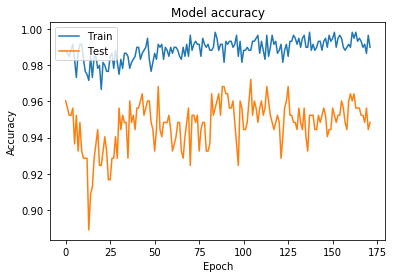

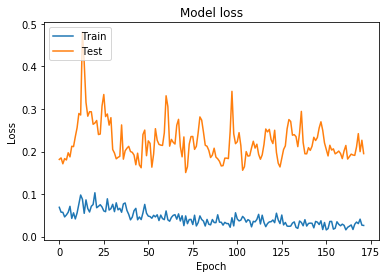

In [10]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[31  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  4]]


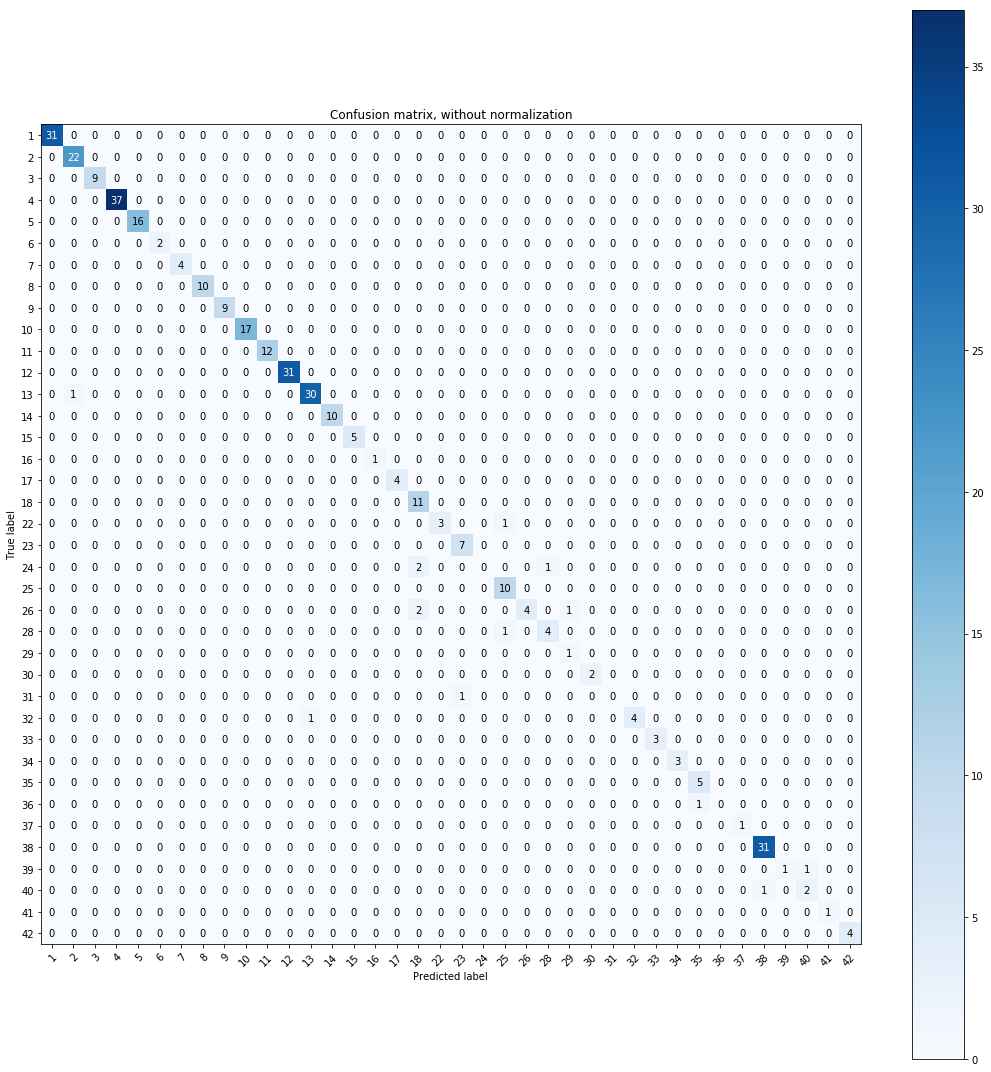

In [14]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    np.argmax(te_labels, axis=1), 
    np.argmax(cnn.predict(te_signs), axis=1), 
    classes=np.array(range(43)),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [ ]:
# serialize model to JSON
model_json = cnn.to_json()
with open("./models/classification_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("./models/classification_model.h5")
print("Saved model to disk")

## Data Augmentation

600
1200


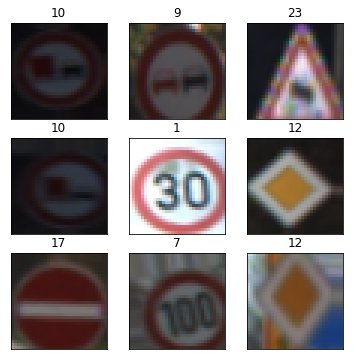

Epoch 1/200
 - 6s - loss: 0.0496 - acc: 0.9846 - val_loss: 0.3992 - val_acc: 0.9365
Epoch 2/200
 - 5s - loss: 0.0730 - acc: 0.9767 - val_loss: 0.2274 - val_acc: 0.9444
Epoch 3/200
 - 5s - loss: 0.0561 - acc: 0.9829 - val_loss: 0.2717 - val_acc: 0.9444
Epoch 4/200
 - 6s - loss: 0.0473 - acc: 0.9852 - val_loss: 0.1520 - val_acc: 0.9683
Epoch 5/200
 - 6s - loss: 0.0405 - acc: 0.9886 - val_loss: 0.2180 - val_acc: 0.9524
Epoch 6/200
 - 5s - loss: 0.0458 - acc: 0.9856 - val_loss: 0.1161 - val_acc: 0.9722
Epoch 7/200
 - 5s - loss: 0.0350 - acc: 0.9881 - val_loss: 0.1283 - val_acc: 0.9643
Epoch 8/200
 - 5s - loss: 0.0406 - acc: 0.9870 - val_loss: 0.1269 - val_acc: 0.9762
Epoch 9/200
 - 5s - loss: 0.0445 - acc: 0.9861 - val_loss: 0.1007 - val_acc: 0.9722
Epoch 10/200
 - 5s - loss: 0.0499 - acc: 0.9849 - val_loss: 0.1489 - val_acc: 0.9643
Epoch 11/200
 - 5s - loss: 0.0460 - acc: 0.9853 - val_loss: 0.1979 - val_acc: 0.9683
Epoch 12/200
 - 5s - loss: 0.0426 - acc: 0.9873 - val_loss: 0.1456 - val_a

In [16]:
from keras.preprocessing.image import ImageDataGenerator

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

print(len(tr_signs))
tr_signs_aug = np.array(tr_signs, copy=True) 
tr_labels_aug = np.array(tr_labels, copy=True)

#datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(tr_signs_aug, augment=True)

# Concatenating the old data with the augmented data
tr_signs_aug  = np.concatenate((tr_signs, tr_signs_aug), axis=0)
tr_labels_aug  = np.concatenate((tr_labels, tr_labels_aug), axis=0)

print(len(tr_signs_aug))

for x_batch, y_batch in datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs_aug) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=128), epochs=200, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard, early_stopping])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

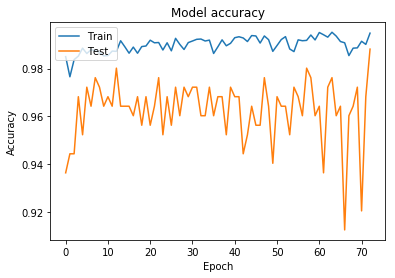

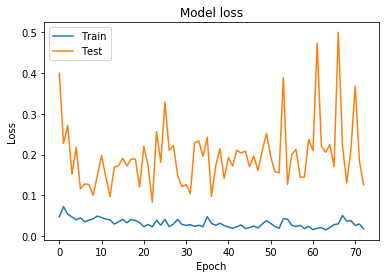

In [17]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[31  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  4]]


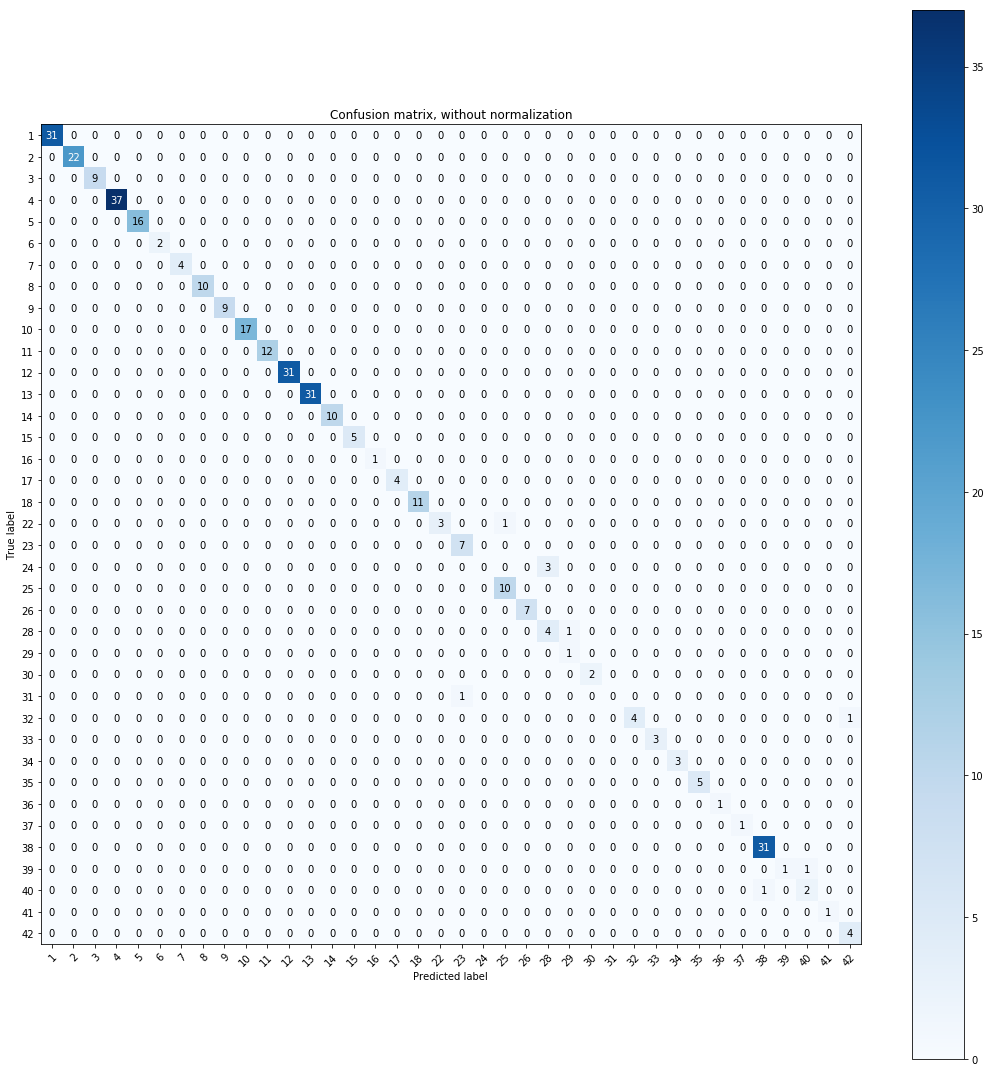

In [19]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    np.argmax(te_labels, axis=1), 
    np.argmax(cnn.predict(te_signs), axis=1), 
    classes=np.array(range(43)),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [20]:
# serialize model to JSON
model_json = cnn.to_json()
with open("./models/classification_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("./models/classification_model.h5")
print("Saved model to disk")

Saved model to disk
